In [111]:
import numpy as np
import pandas as pd
from sqlalchemy import create_engine
import seaborn as sns
from mpl_toolkits.basemap import Basemap
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib import colors
from matplotlib.colorbar import ColorbarBase
from matplotlib.cm import ScalarMappable
from matplotlib.patches import Polygon


In [112]:
engine = create_engine('postgresql://localhost:5432/ifprates')

In [147]:
df = pd.read_sql_query('SELECT * FROM reports.v_enrollment_summary_dataset', engine)

In [149]:
sorted(df.columns)


['businessyear',
 'category',
 'count_bronze',
 'count_cat',
 'count_gold',
 'count_silver',
 'county_name',
 'fips_code',
 'fips_code_5_digit',
 'index',
 'insured_below138fpl',
 'insured_subsidy_elig',
 'issuer_count',
 'max_price_bronze',
 'max_price_cat',
 'max_price_gold',
 'max_price_silver',
 'mean_price_bronze',
 'mean_price_cat',
 'mean_price_gold',
 'mean_price_silver',
 'min_price_bronze',
 'min_price_cat',
 'min_price_gold',
 'min_price_silver',
 'pct_below138fpl_uninsured',
 'pct_change_count_bronze',
 'pct_change_count_cat',
 'pct_change_count_gold',
 'pct_change_count_silver',
 'pct_change_issuer_count',
 'pct_change_mean_price_bronze',
 'pct_change_mean_price_cat',
 'pct_change_mean_price_gold',
 'pct_change_mean_price_silver',
 'pct_change_min_price_bronze',
 'pct_change_min_price_cat',
 'pct_change_min_price_gold',
 'pct_change_min_price_silver',
 'pct_change_second_lowest_silver',
 'pct_subsidy_elig_uninsured',
 'poverty_to_subsidy_ratio',
 'prior_count_bronze',
 'pr

In [15]:
years = df.businessyear.unique()
years

array([2014, 2015, 2016, 2017, 2018])

In [16]:
# set the colormap and centre the colorbar
class MidpointNormalize(colors.Normalize):
    """
    Normalise the colorbar so that diverging bars work there way either side from a prescribed midpoint value)

    e.g. im=ax1.imshow(array, norm=MidpointNormalize(midpoint=0.,vmin=-100, vmax=100))
    """
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y), np.isnan(value))

In [18]:
def create_map_layer():
    lllon = -119
    urlon = -64
    lllat = 22.0
    urlat = 50.5
    # and calculate a centerpoint, needed for the projection:
    centerlon = float(lllon + urlon) / 2.0
    centerlat = float(lllat + urlat) / 2.0

    m = Basemap(resolution='i',  # crude, low, intermediate, high, full
                llcrnrlon = lllon, urcrnrlon = urlon,
                lon_0 = centerlon,
                llcrnrlat = lllat, urcrnrlat = urlat,
                lat_0 = centerlat,
                projection='tmerc')

    # Read state boundaries.
    shp_info = m.readshapefile("shapefiles/census_state_shapes_2016/cb_2016_us_state_500k", 'states',
                               drawbounds=True, color='lightgrey')

    # Read county boundaries
    shp_info = m.readshapefile('shapefiles/census_county_shapes_2016/cb_2016_us_county_500k',
                               'counties',
                               drawbounds=True)
    return m

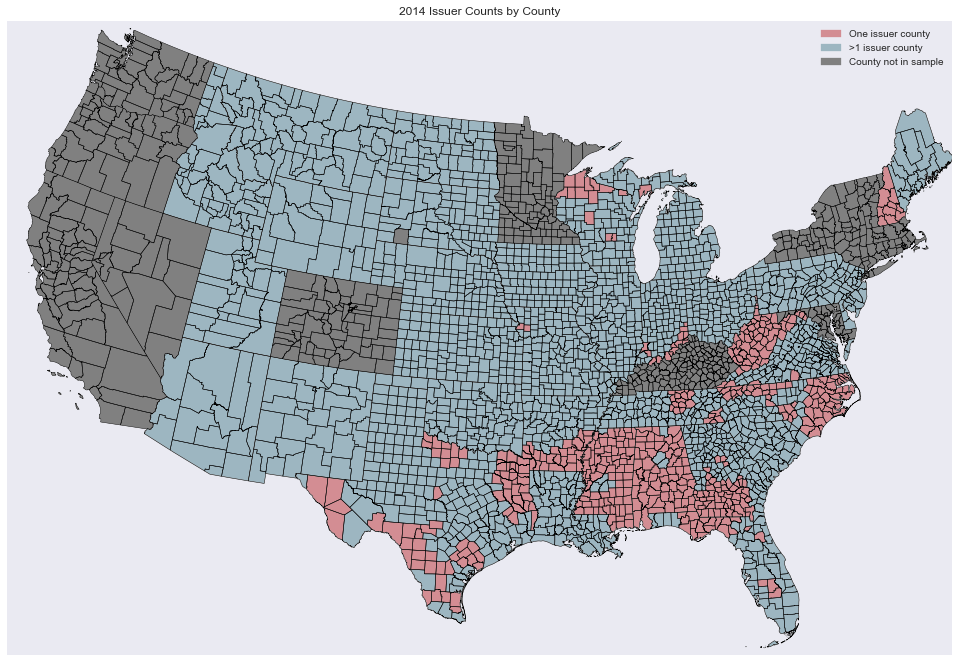

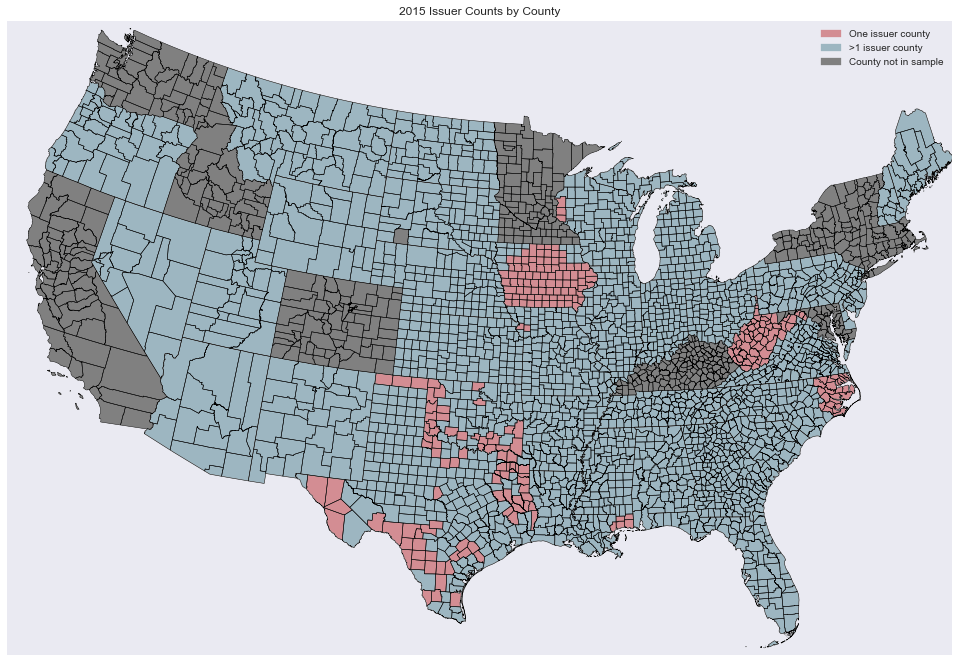

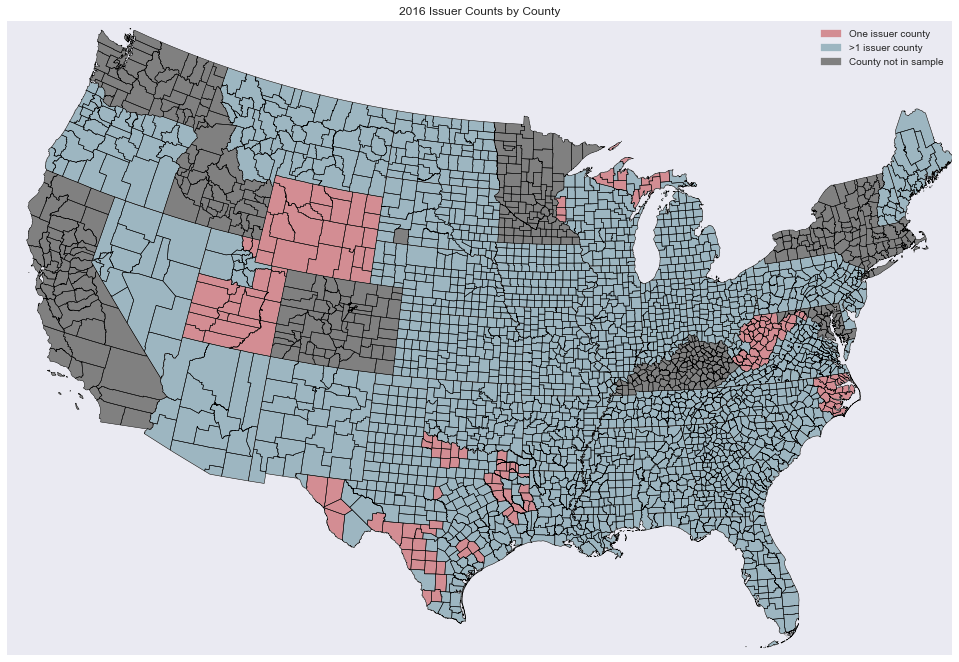

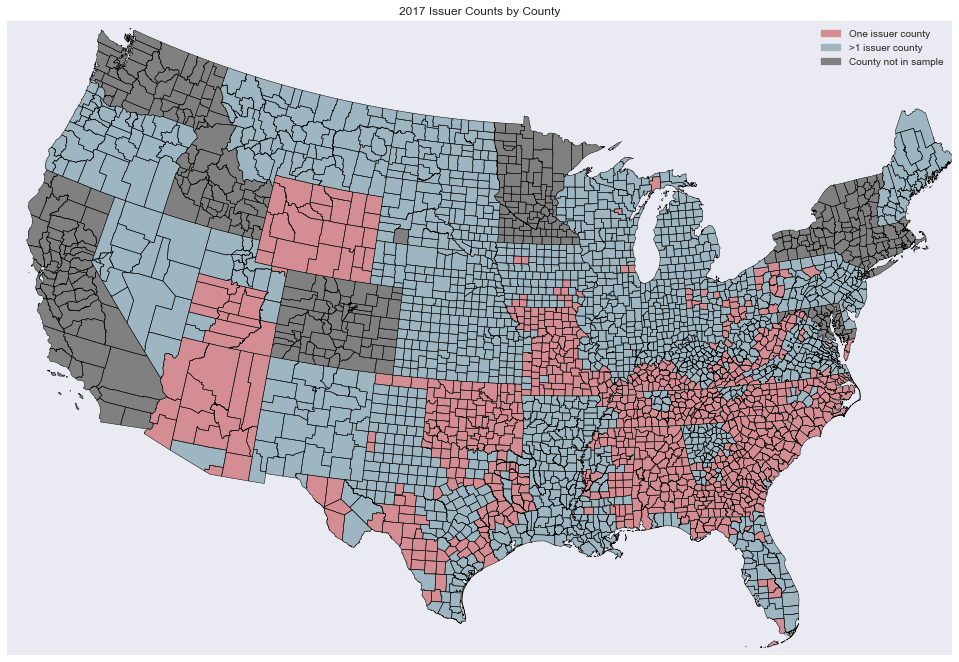

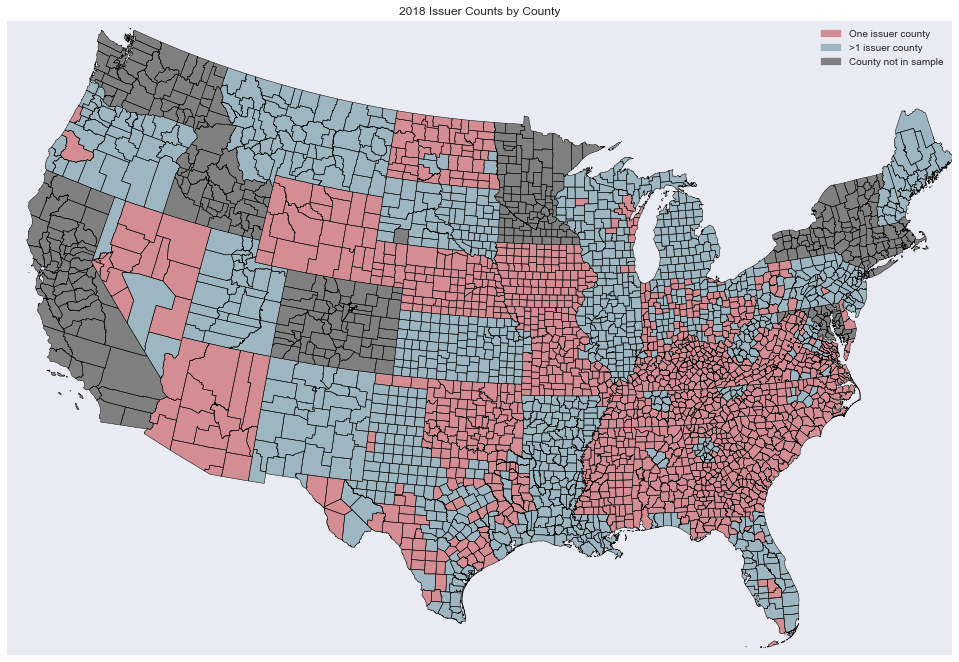

In [223]:
def plot_count_issuer_counts(year):
    f, ax = plt.subplots()

    m = create_map_layer()

    one_issuer_color = '#D38D93'
    morethanone_issuer_color = '#9DB6C1'
    no_data_color = 'grey'
    
    dfyear = df[df['businessyear'] == year]

    for i, county in enumerate(m.counties_info):
        idx = i
        geoid = county['GEOID']
        try:
            count = dfyear.loc[dfyear['fips_code_5_digit'] == geoid, 'issuer_count'].iloc[0]
        except:
            count = 'na'
        if count == 'na':
            color = no_data_color
        elif count == 1:
            color = one_issuer_color
        else:
            color = morethanone_issuer_color
        li = [idx, geoid, count, color]
        poly = Polygon(m.counties[li[0]], facecolor=li[3])  # edgecolor="white"
        ax.add_patch(poly)
    
    one_issuer_patch = mpatches.Patch(color=one_issuer_color, label='One issuer county')
    morethanone_issuer_patch = mpatches.Patch(color=morethanone_issuer_color, label='>1 issuer county')
    no_data_patch = mpatches.Patch(color=no_data_color, label='County not in sample')

    ax.set_title('%r Issuer Counts by County' % year)
    
    plt.legend(handles=[one_issuer_patch,morethanone_issuer_patch,no_data_patch])
    f.set_size_inches(14,9)
    plt.tight_layout(pad=0, w_pad=0, h_pad=0)
    plt.show()


for year in years:
    plot_count_issuer_counts(year=year)
    
    
    

In [224]:
def plot_pct_map_year(df, pct_col, year, title):
    f, ax = plt.subplots()
    m = create_map_layer()

    cmap = sns.diverging_palette(220, 10, as_cmap=True)
    vmin = df[pct_col].min()
    vmax = df[pct_col].max()
    norm = MidpointNormalize(midpoint=0.,vmin=vmin, vmax=vmax)
    mapper = ScalarMappable(norm=norm, cmap=cmap)
    
    df_year = df[df['businessyear'] == year]

    no_data_color = 'grey'
            
    for i, county in enumerate(m.counties_info):
        idx = i
        geoid = county['GEOID']
        try:
            pct = df_year.loc[df_year['fips_code_5_digit'] == geoid, pct_col].iloc[0]
        except:
            pct = 'na'
        if pct == 'na':
            color = no_data_color
        elif np.isnan(pct):
            color = no_data_color
        else:
            color = mapper.to_rgba(pct)
        li = [idx, geoid, pct, color]
        poly = Polygon(m.counties[li[0]], facecolor=rgb2hex(li[3]))
        ax.add_patch(poly)
    
    
    no_data_patch = mpatches.Patch(color=no_data_color, label='County not in sample')

    ax.set_title(title % year)
    
    plt.legend(handles=[no_data_patch])
    
    plt.tight_layout(pad=1, w_pad=0, h_pad=0)
    cax = f.add_axes([0.125, -0.05, 0.775, 0.025]) # posititon
    cb = ColorbarBase(cax,cmap=cmap,norm=norm, orientation='horizontal')
    f.set_size_inches(14,9)
    cb.ax.set_xlabel('Percent Change')
    plt.show()



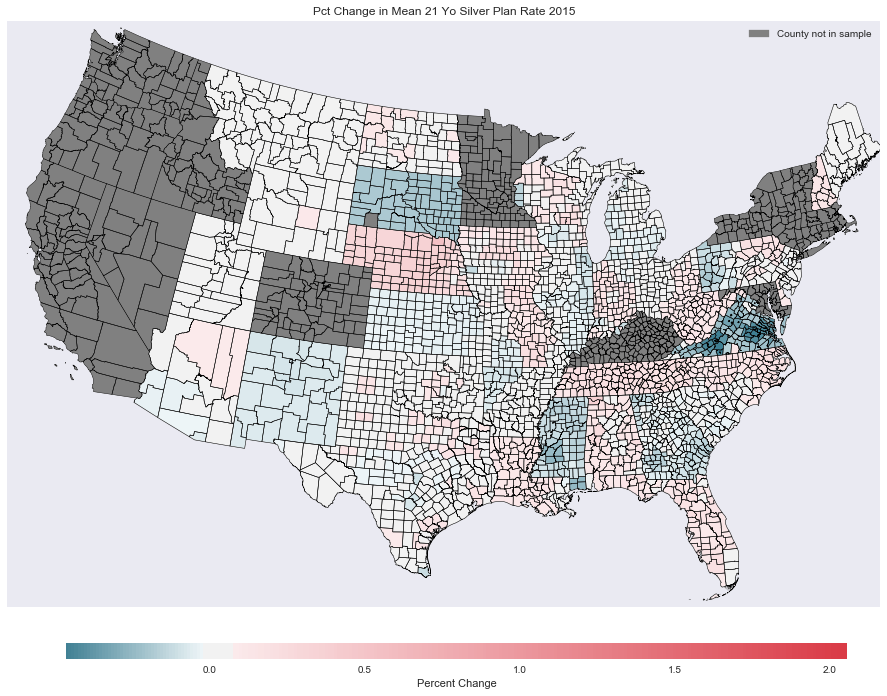

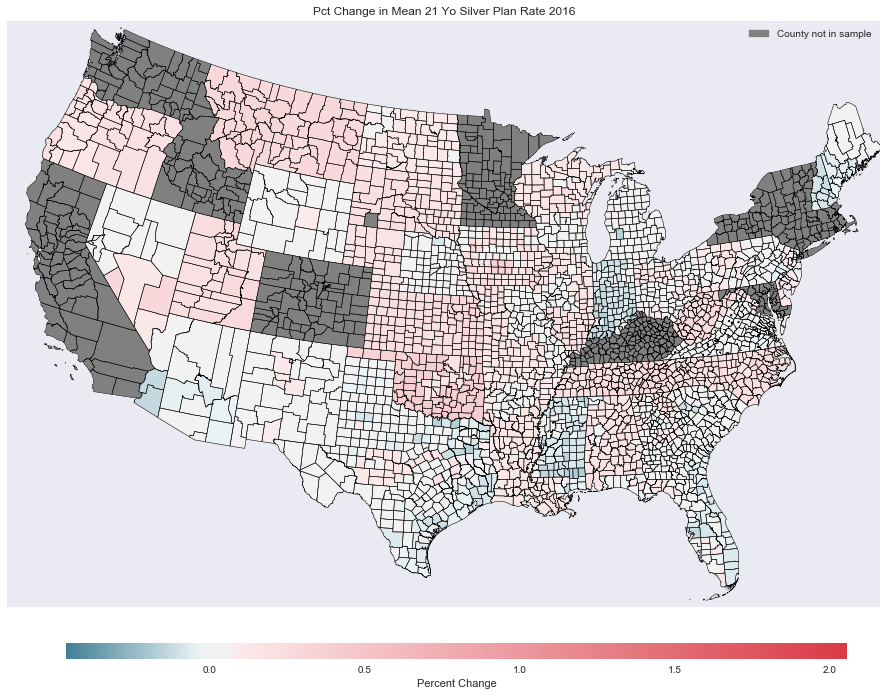

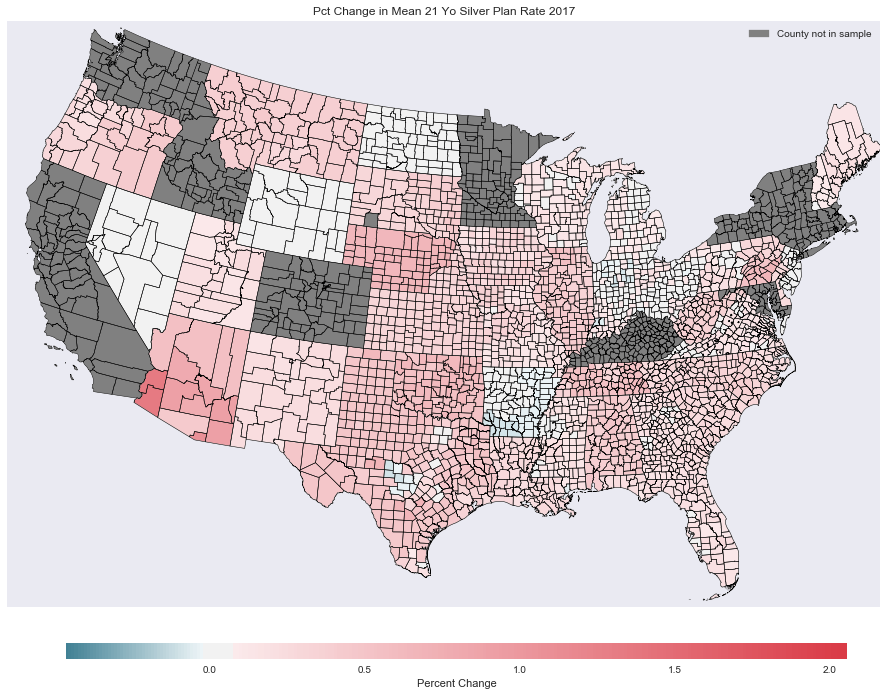

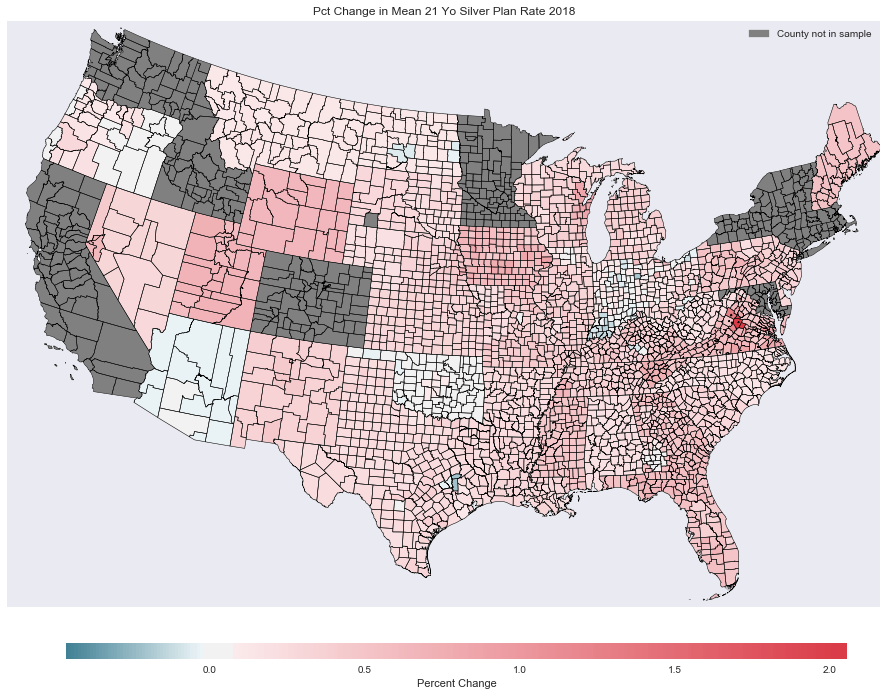

In [225]:
for year in [2015,2016,2017,2018]:
    plot_pct_map_year(df=df,pct_col='pct_change_mean_price_silver', year=year, title='Pct Change in Mean 21 Yo Silver Plan Rate %r')


In [180]:
def plot_pct_map(df, pct_col, title):
    f, ax = plt.subplots()
    m = create_map_layer()

    cmap = sns.diverging_palette(220, 10, as_cmap=True)
    vmin = df[pct_col].min()
    vmax = df[pct_col].max()
    norm = MidpointNormalize(midpoint=0.,vmin=vmin, vmax=vmax)
    mapper = ScalarMappable(norm=norm, cmap=cmap)


    no_data_color = 'grey'
            
    for i, county in enumerate(m.counties_info):
        idx = i
        geoid = county['GEOID']
        try:
            pct = df.loc[df['fips_code_5_digit'] == geoid, pct_col].iloc[0]
        except:
            pct = 'na'
        if pct == 'na':
            color = no_data_color
        elif np.isnan(pct):
            color = no_data_color
        else:
            color = mapper.to_rgba(pct)
        li = [idx, geoid, pct, color]
        poly = Polygon(m.counties[li[0]], facecolor=rgb2hex(li[3]))
        ax.add_patch(poly)
    
    
    no_data_patch = mpatches.Patch(color=no_data_color, label='County not in sample')

    
    plt.legend(handles=[no_data_patch])
    
    ax.set_title(label=title)

    plt.tight_layout(pad=1, w_pad=0, h_pad=0)
    cax = f.add_axes([0.125, -0.05, 0.775, 0.025]) # posititon
    cb = ColorbarBase(cax,cmap=cmap,norm=norm, orientation='horizontal')
    f.set_size_inches(18.5, 10.5, forward=True)
    cb.ax.set_xlabel('Percent Change')
    plt.show()


In [186]:
df_min_silver = df.pivot(index= 'fips_code_5_digit', columns='businessyear', values='mean_price_bronze').reset_index()
df_min_silver['Mean Bronze Rate Increase 2014-18'] = ( df_min_silver[2018] - df_min_silver[2014])/ df_min_silver[2014]
df_min_silver.head()

businessyear fips_code_5_digit    2014      2015        2016     2017  \
0                        01001  152.88  169.1175  209.906667  261.215   
1                        01003  148.00  168.2375  206.756667  252.880   
2                        01005  148.00  168.2375  206.756667  252.880   
3                        01007  162.64  177.7750  219.516667  277.890   
4                        01009  162.64  177.7750  212.437500  277.890   

businessyear     2018  Mean Bronze Rate Increase 2014-18  
0             273.665                           0.790064  
1             264.925                           0.790034  
2             264.925                           0.790034  
3             291.130                           0.790027  
4             291.130                           0.790027

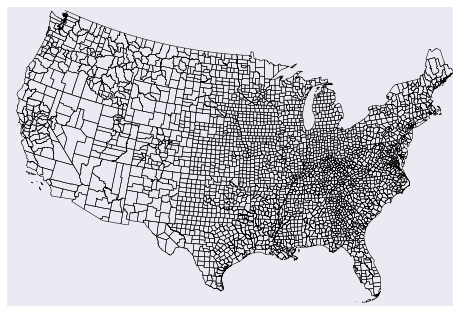

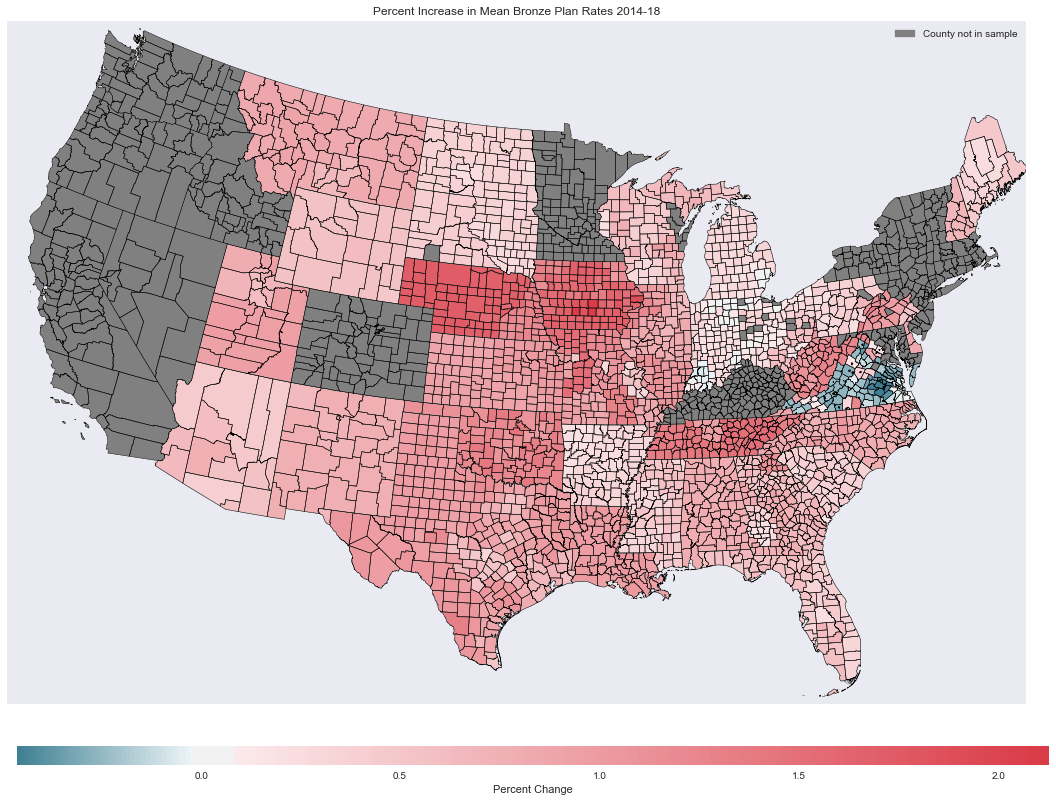

In [187]:
plot_pct_map(df=df_min_silver, pct_col='Mean Bronze Rate Increase 2014-18', title='Percent Increase in Mean Bronze Plan Rates 2014-18')

In [171]:
df_mean_silver = df.pivot(index= 'fips_code_5_digit', columns='businessyear', values='mean_price_silver').reset_index()
df_mean_silver['Mean Silver Rate Increase 2014-18'] = ( df_mean_silver[2018] - df_mean_silver[2014])/ df_mean_silver[2014]
df_mean_silver.head()

businessyear fips_code_5_digit     2014        2015        2016     2017  \
0                        01001  195.225  209.940000  244.735714  349.235   
1                        01003  189.000  210.610000  242.098571  338.090   
2                        01005  189.000  210.610000  242.098571  338.090   
3                        01007  207.690  219.858333  254.837143  371.525   
4                        01009  207.690  219.858333  251.170000  371.525   

businessyear     2018  Mean Silver Rate Increase 2014-18  
0             418.615                           1.144269  
1             405.255                           1.144206  
2             405.255                           1.144206  
3             445.335                           1.144229  
4             445.335                           1.144229

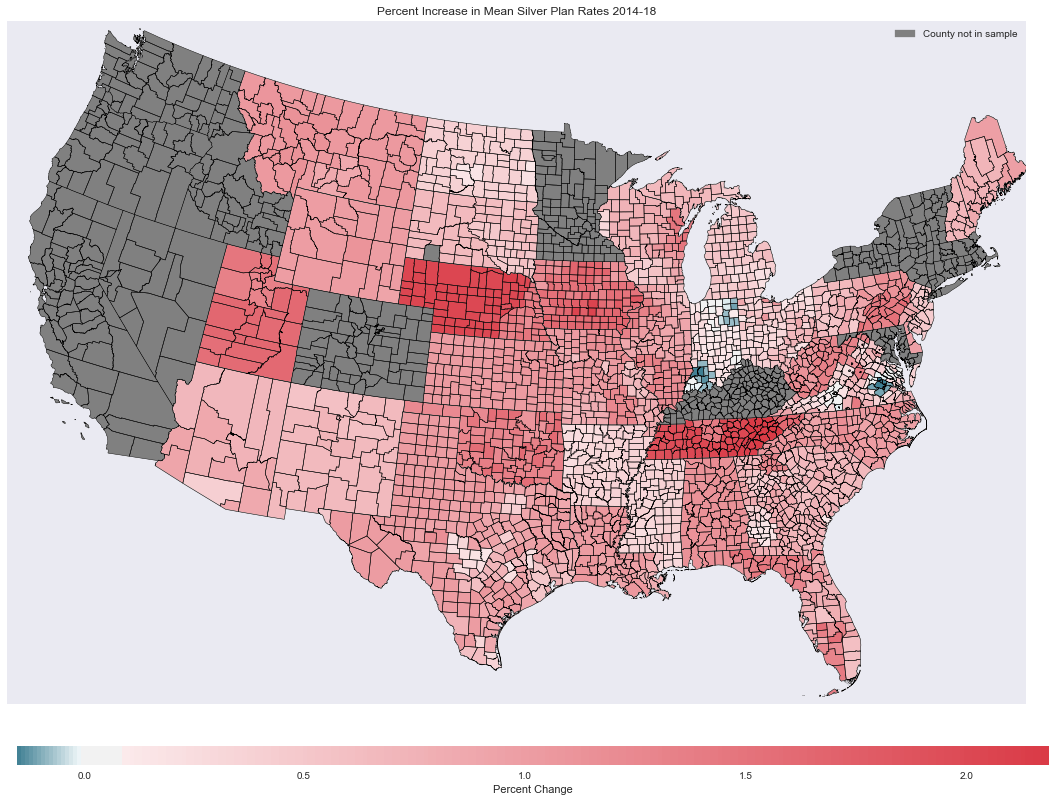

In [184]:
plot_pct_map(df=df_mean_silver, pct_col= 'Mean Silver Rate Increase 2014-18',title='Percent Increase in Mean Silver Plan Rates 2014-18')
plt.show()

In [190]:
plan_rates_df = pd.read_sql_query(
    'SELECT \
    ic.businessyear\
    ,ic.fips_code\
    ,ic.issuer_count\
    ,mtcp.mean_metal_tier_price AS "Mean Plan Rate"\
    ,mtcp.metallevel\
    ,mtcp.metalid\
    ,mtcp.min_metal_tier_price AS "Min Plan Rate"\
    ,mtcp.metallevel AS "Metal Tier"\
    FROM reports.v_issuer_counts AS ic\
    LEFT JOIN reports.v_metal_tier_counts_prices AS mtcp\
        ON ic.fips_code = mtcp.fips_code\
        AND ic.businessyear = mtcp.businessyear\
    WHERE mtcp.metalid IN (1, 3)', #1 = bronse, #3 = silver, #4 = gold
    engine) 

In [191]:
# plan_rates_df_cleaned = plan_rates_df[(plan_rates_df['metallevel'] == 'Silver') | (plan_rates_df['metallevel'] =='Bronze') ]
plan_rates_df['Issuer Counts'] = np.where(plan_rates_df['issuer_count'] >=5, '5+', plan_rates_df['issuer_count'])
plan_rates_df.sort_values(by=['businessyear', 'Issuer Counts', 'metalid'], axis=0, ascending=True, inplace=True)
plan_rates_df.head()

businessyear  fips_code  issuer_count  Mean Plan Rate metallevel  metalid  \
58          2014     1001.0             1          152.88     Bronze        1   
60          2014     1003.0             1          148.00     Bronze        1   
62          2014     1005.0             1          148.00     Bronze        1   
64          2014     1007.0             1          162.64     Bronze        1   
66          2014     1009.0             1          162.64     Bronze        1   

    Min Plan Rate Metal Tier Issuer Counts  
58         152.88     Bronze             1  
60         148.00     Bronze             1  
62         148.00     Bronze             1  
64         162.64     Bronze             1  
66         162.64     Bronze             1

In [192]:
plan_rates_years = plan_rates_df.businessyear.unique()
plan_rates_years

array([2014, 2015, 2016, 2017, 2018])

In [197]:
def plot_rate_violins(df, year, y, x, hue, title):
    colors = ["tan", "silver", "gold", "faded green", "dusty purple"]
    fig, ax = plt.subplots()
#     ax = sns.violinplot(
    ax = sns.boxplot(
        x=x, 
        y=y,
        data=df[df['businessyear'] == year], 
        hue=hue,
#         size=12, aspect=.7,
        palette=colors).set_title(title % year)
    
    fig.set_size_inches(14,9)
    
    plt.show()
    



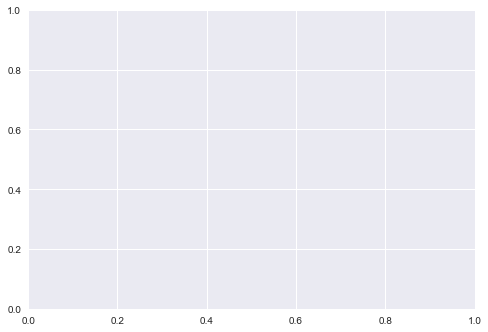

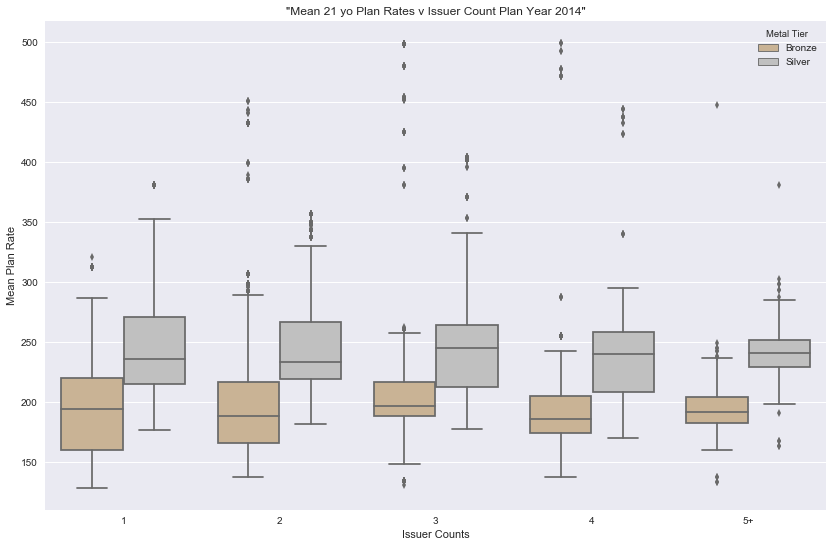

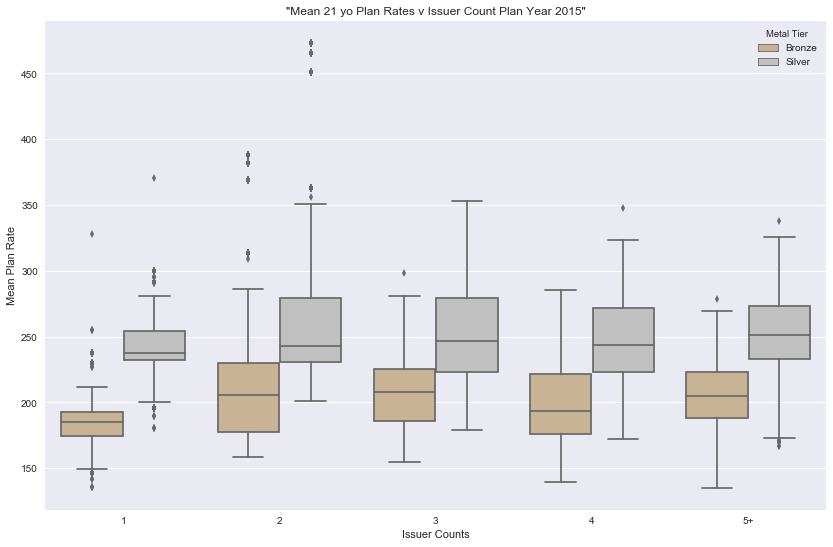

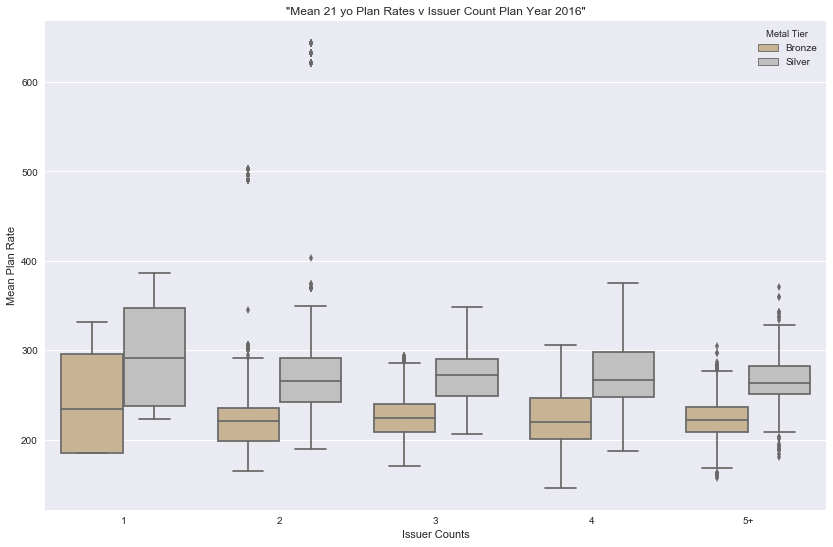

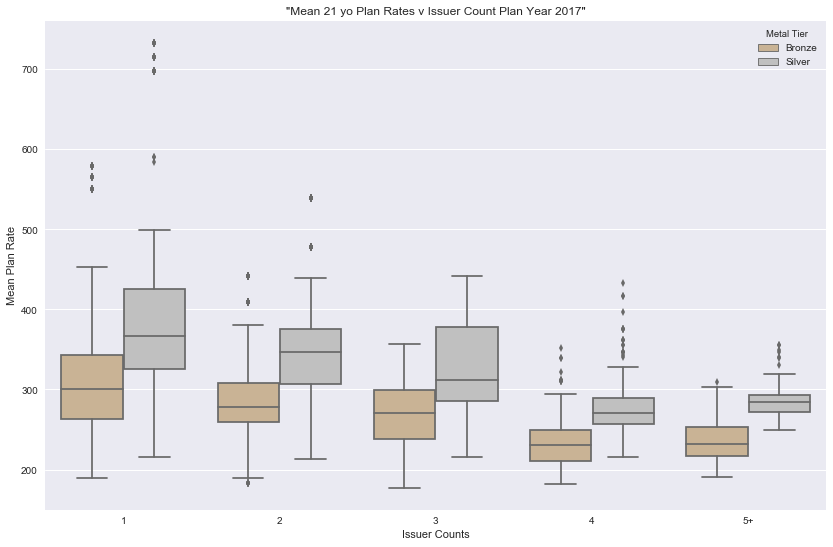

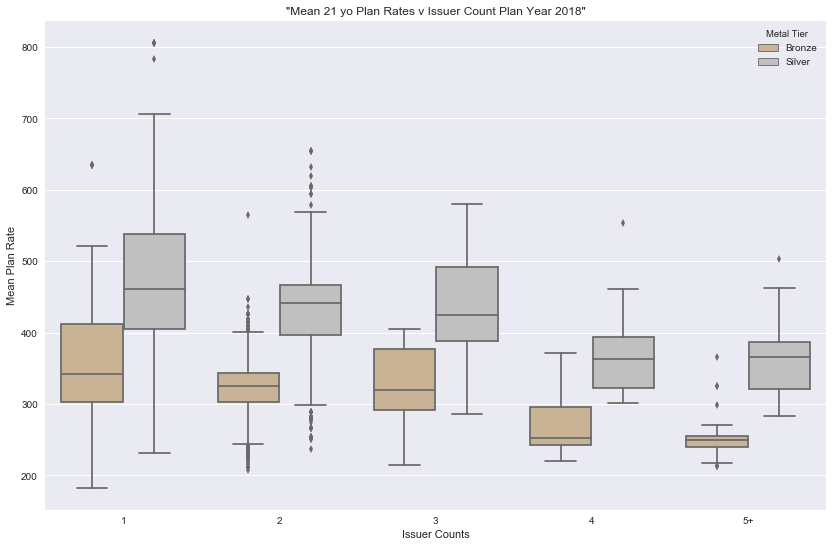

In [198]:
for year in plan_rates_years:
    plot_rate_violins(df=plan_rates_df, year=year, x='Issuer Counts', y='Mean Plan Rate', hue='Metal Tier', title='"Mean 21 yo Plan Rates v Issuer Count Plan Year %r"')

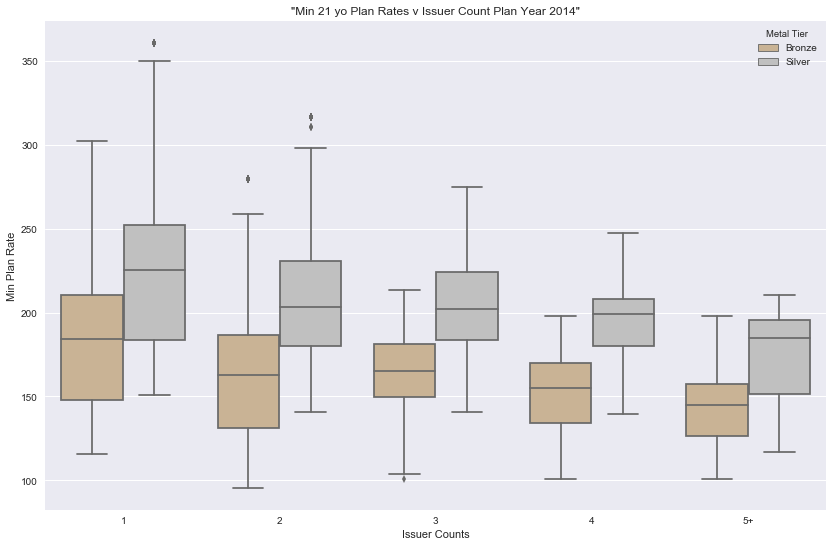

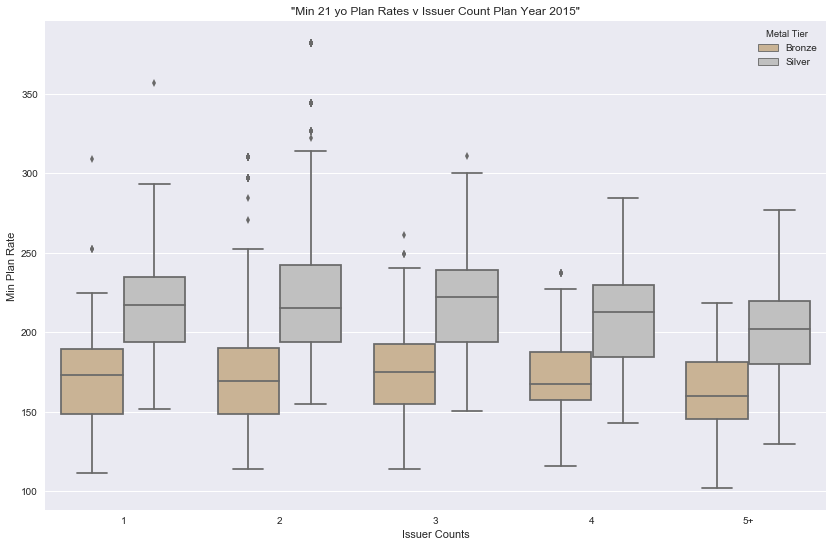

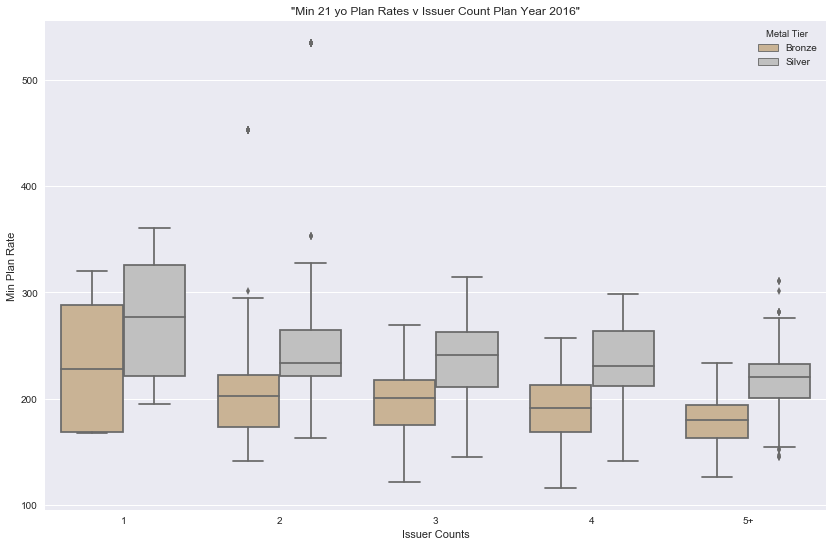

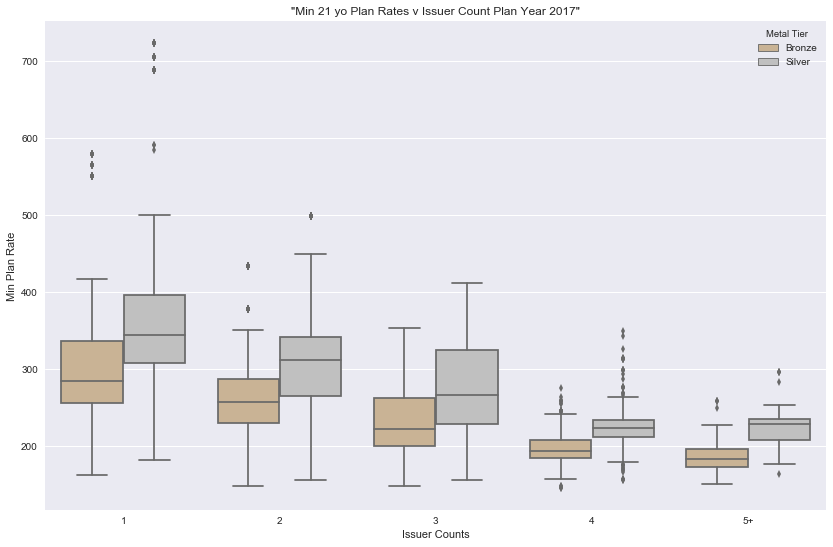

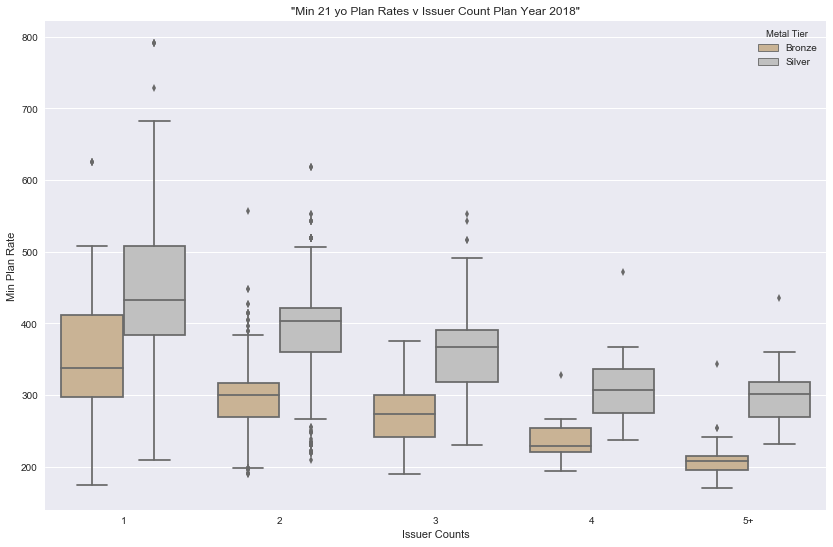

In [199]:
for year in plan_rates_years:
    plot_rate_violins(df=plan_rates_df, year=year, x='Issuer Counts', y='Min Plan Rate', hue='Metal Tier', title='"Min 21 yo Plan Rates v Issuer Count Plan Year %r"')

In [210]:
pop_issuer_count_df = df[['businessyear', 'fips_code', 'issuer_count', 'total_subsidy_elig', 'total_below138fpl']]


In [211]:
pop_issuer_count_df['Issuer Counts'] = np.where(pop_issuer_count_df['issuer_count'] >=5, '5+', pop_issuer_count_df['issuer_count'])


/Users/jakram/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [212]:
pop_issuer_count_grouped_df = pop_issuer_count_df.groupby(['businessyear', 'Issuer Counts']).agg(
    {
        'total_subsidy_elig' : np.sum,
        'total_below138fpl' : np.sum,
        'fips_code' : np.count_nonzero
    }
)


In [213]:
subsidy_pop_by_issuer_count = pop_issuer_count_grouped_df.reset_index()
subsidy_pop_by_issuer_count = subsidy_pop_by_issuer_count.pivot(index='businessyear', columns='Issuer Counts', values='total_subsidy_elig')
subsidy_pop_by_issuer_count

Issuer Counts         1.0         2.0         3.0         4.0          5+
businessyear                                                             
2014            6791652.0  13995022.0  12503180.0  15886873.0  23892135.0
2015            2923687.0   6676705.0   9792010.0  11374686.0  44106190.0
2016            1800292.0   9668244.0  12810122.0  14661241.0  35933379.0
2017           17053388.0  17664419.0  22469159.0  10095544.0   9160779.0
2018           25960449.0  20610998.0  13242944.0  11989162.0   4639736.0

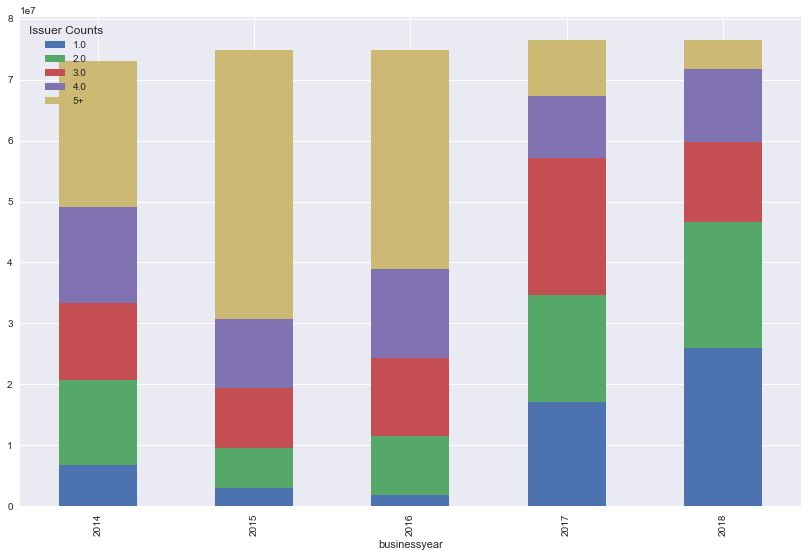

In [214]:
fig, ax = plt.subplots()
subsidy_pop_by_issuer_count.plot.bar(stacked=True, ax=ax)
fig.set_size_inches(14,9)
plt.show()

In [217]:
medicaid_pop_by_issuer_count = pop_issuer_count_grouped_df.reset_index()
medicaid_pop_by_issuer_count = medicaid_pop_by_issuer_count.pivot(index='businessyear', columns='Issuer Counts', values='total_below138fpl')
medicaid_pop_by_issuer_count

Issuer Counts         1.0         2.0         3.0        4.0          5+
businessyear                                                            
2014            4483081.0   7749501.0   6974690.0  8738637.0  13122039.0
2015            1634032.0   4068639.0   5388744.0  6403339.0  24604550.0
2016            1049209.0   5930742.0   7142051.0  7819381.0  20157921.0
2017           10566110.0   9501800.0  12053554.0  5897406.0   5064440.0
2018           15300312.0  10606362.0   7740472.0  6809535.0   2626629.0

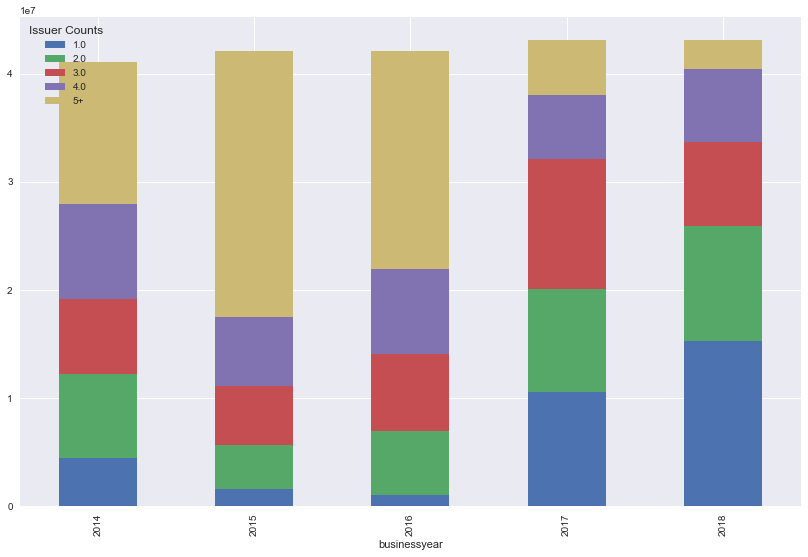

In [218]:
fig, ax = plt.subplots()
subsidy_pop_by_issuer_count.plot.bar(stacked=True, ax=ax)
fig.set_size_inches(14,9)
plt.show()

In [216]:
metal_tier_elections_df = df.groupby(['businessyear']).agg(
    {
        'tier_catastrophic' : np.sum,
        'tier_bronze' : np.sum,
        'tier_silver' : np.sum,
        'tier_gold' : np.sum,
        'tier_platinum' : np.sum,
    }
)
metal_tier_elections_df.reset_index(inplace=True)
metal_tier_elections_df

businessyear  tier_catastrophic  tier_bronze  tier_silver  tier_gold  \
0          2014                NaN          NaN          NaN        NaN   
1          2015            67780.0    1857547.0    6076616.0   537689.0   
2          2016            91967.0    2046312.0    6801196.0   546094.0   
3          2017            64548.0    1938000.0    6804203.0   267336.0   
4          2018                NaN          NaN          NaN        NaN   

   tier_platinum  
0            NaN  
1       217653.0  
2        67904.0  
3        20324.0  
4            NaN

In [ ]:
ct.plot.bar(stacked=True)
plt.legend(title='mark')
plt.show()